In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import HTML

# What is intracranial hemorrhage?

Hmm, let's watch a video! :-)

In [2]:
HTML('<iframe width="800" height="500" src="https://www.youtube.com/embed/Kb_wzb7-rvE" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Thank you Armando! I have no medical background and this was really great to understand the topic better! :-)

## Our goal

We are asked to predict the occurence and the subtype of intracranial hemorrhage. For this purpose we have to make 6 decisions per image: 5 subtypes and if there is an occurence (any).

## Table of contents

1. [Prepare to start](#prepare)
2. [Exploratory analysis](#explore)
    * [Sample submission](#sample_submission)
    * [Evaluation metric](#evaluate)
    * [Target distribution](#targets)
    * [Number of samples](#num_samples)
3. [Preprocessing dicom files](#dicom)
    * [What is given by a dicom file?](#dicomfile)
    * [Why can't we see something without windowing?](#aboutwindows)
    * [What is covered by raw pixel values?](#pixelarray)
    * [What does pixelspacing mean?](#pixelspacing)
    * [The doctors windows](#docwindows)
    * [My custom window](#customwindow)
    * [The image shape](#imageshape)

# Prepare to start <a class="anchor" id="prepare"></a>

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16

from keras.utils import Sequence

listdir("../input/rsna-intracranial-hemorrhage-detection/")

Using TensorFlow backend.


['stage_1_sample_submission.csv',
 'stage_1_train.csv',
 'stage_1_test_images',
 'stage_1_train_images']

In [4]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/"

# Exploratory analysis <a class="anchor" id="explore"></a>

## Sample Submission <a class="anchor" id="sample_submission"></a>

In [5]:
submission = pd.read_csv(INPUT_PATH + "stage_1_sample_submission.csv")
submission.head(10)

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5
5,ID_28fbab7eb_any,0.5
6,ID_877923b8b_epidural,0.5
7,ID_877923b8b_intraparenchymal,0.5
8,ID_877923b8b_intraventricular,0.5
9,ID_877923b8b_subarachnoid,0.5


We can clearly see that we have to make several predictions for one image id:

* epidural 
* subdural 
* subarachnoid 
* intraparenchymal 
* intraventricular 
* any - this one indicates that at least one subtype is present, hence it tells us if the patient has IH or not.

## Evaluation metric <a class="anchor" id="evaluate"></a>

The **weighted multilabel logarithmic loss** is used to score our model performance. In the description it's given that the log loss is first taken for each subtype $s$ given an image id $n$:

$$l_{n,s} = t_{n,s} \cdot \ln(y_{n,s}) + (1-t_{n,s}) \cdot \ln(1-y_{n,s}) $$  

Then they seem to be added, whereas the any-subtype obtains a higher weight than the others:

$$ l_{n} = \sum_{s} w_{s} \cdot l_{n,s} $$

And finally this loss is averaged over all samples:

$$ Loss = -\frac{1}{N} \cdot \sum_{n} l_{n} $$

Hopefully I got this right! ;-) 

Interestingly the competition host has not provided the weights (or did they?). Hence this is going to be an LB probing hyperparameter to keep in mind.

## Target distribution <a class="anchor" id="targets"></a>

In [6]:
traindf = pd.read_csv(INPUT_PATH + "stage_1_train.csv")
traindf.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [7]:
label = traindf.Label.values

In [8]:
traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
traindf.head()

,0,1,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


In [9]:
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
subtype_counts = traindf.groupby("subtype").label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1] / traindf.groupby("subtype").size() * 100

In [10]:
traindf.head()

,id,subtype,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


We need the same for our test data later:

In [11]:
testdf = submission.ID.str.rsplit("_", n=1, expand=True)
testdf = testdf.rename({0: "id", 1: "subtype"}, axis=1)
testdf.loc[:, "label"] = 0
testdf.head()

,id,subtype,label
0,ID_28fbab7eb,epidural,0
1,ID_28fbab7eb,intraparenchymal,0
2,ID_28fbab7eb,intraventricular,0
3,ID_28fbab7eb,subarachnoid,0
4,ID_28fbab7eb,subdural,0


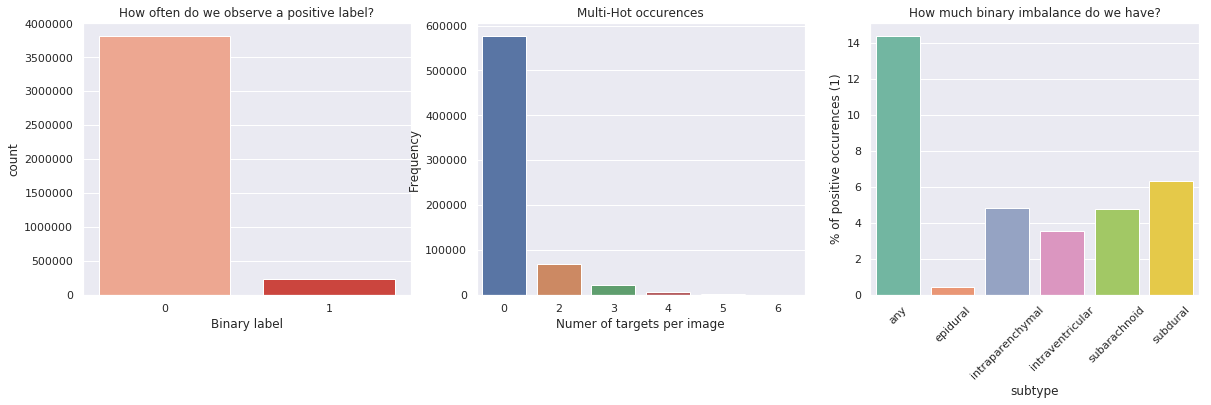

In [12]:
multi_target_count = traindf.groupby("id").label.sum()

fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.countplot(traindf.label, ax=ax[0], palette="Reds")
ax[0].set_xlabel("Binary label")
ax[0].set_title("How often do we observe a positive label?");

sns.countplot(multi_target_count, ax=ax[1])
ax[1].set_xlabel("Numer of targets per image")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Multi-Hot occurences")

sns.barplot(x=subtype_counts.index, y=subtype_counts.values, ax=ax[2], palette="Set2")
plt.xticks(rotation=45); 
ax[2].set_title("How much binary imbalance do we have?")
ax[2].set_ylabel("% of positive occurences (1)");


### Insights

* The first image already shows that we will have much more zero occurences than positive target values.
* Going into details of each subtype we can see that we have to deal with high class imbalance. 
* Epidural is the worst case. For this type we only have a few (< 1%) of positive occurrences. It will be difficult to train a model that is robust enough and does not tend to overfit.

## Number of samples <a class="anchor" id="num_samples"></a>

In [13]:
traindf.head()

,id,subtype,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


In [14]:
traindf.id.nunique()

674258

Let's check whether this matches the number of train images we have:

In [15]:
train_dir = INPUT_PATH + "stage_1_train_images/"
train_files = listdir(train_dir)

In [16]:
train_size = len(train_files)
train_size

674258

Ok, as expected.

In [17]:
test_dir = INPUT_PATH + "stage_1_test_images/"
test_files = listdir(test_dir)
test_size = len(test_files)
test_size

78545

In [18]:
train_size/test_size

8.58435291870902

Ok, in this stage 1 we have almost 8.6 times more training images than the test data.

# Preprocessing dicom files <a class="anchor" id="dicom"></a>

In [19]:
train_files[0:10]

['ID_231d901c1.dcm',
 'ID_994bc0470.dcm',
 'ID_127689cce.dcm',
 'ID_25457734a.dcm',
 'ID_81c9aa125.dcm',
 'ID_87e8b2528.dcm',
 'ID_9bc43a883.dcm',
 'ID_df0ba5e5a.dcm',
 'ID_69eb48ed6.dcm',
 'ID_c5c23af94.dcm']

Ok, the filename is given by the *ID_alphanum* column. As we have used str.rsplit of pandas we are lucky and can easily load images given the id column: 

In [20]:
subtypes = traindf.subtype.unique()
subtypes

array(['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid',
       'subdural', 'any'], dtype=object)

## What is given by a dicom file? <a class="anchor" id="dicomfile"></a>

In [21]:
dataset = pydicom.dcmread(train_dir + "ID_c5c23af94.dcm")
print(dataset)

(0008, 0018) SOP Instance UID                    UI: ID_c5c23af94
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_9630cc49'
(0020, 000d) Study Instance UID                  UI: ID_c5409f3ace
(0020, 000e) Series Instance UID                 UI: ID_5db30227b2
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000', '-118.882', '33.678']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.951057', '-0.309017']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored          

## Why can't we see something without windowing? <a class="anchor" id="aboutwindows"></a>

I haven't worked often with dicom images so far, so I still get confused why we have someting like window center, width and rescale parameters. So I decided to watch a video about understanding CT images. You can speed up a bit if you like by starting at ~7min:


In [22]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/KZld-5W99cI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

Ok, I learnt... 

* that hounsfield units are a measurement to describe radiodensity. 
* different tissues have different HUs.
* Our eye can only detect ~6% change in greyscale (16 shades of grey).
* Given 2000 HU of one image (-1000 to 1000), this means that 1 greyscale covers 8 HUs.
* Consequently there can happen a change of 120 HUs unit our eye is able to detect an intensity change in the image.
* The example of a hemorrhage in the brain shows relevant HUs in the range of 8-70. We won't be able to see important changes in the intensity to detect the hemorrhage. 
* This is the reason why we have to focus 256 shades of grey into a small range/window of HU units. (WINDOW)
* The level means where this window is centered.


## What is covered by raw pixel values? <a class="anchor" id="pixelarray"></a>

No! If we browse through the dicom files, we can see that this is not true. Let's see how different dicom datasets differ in the distribution of pixel array values:

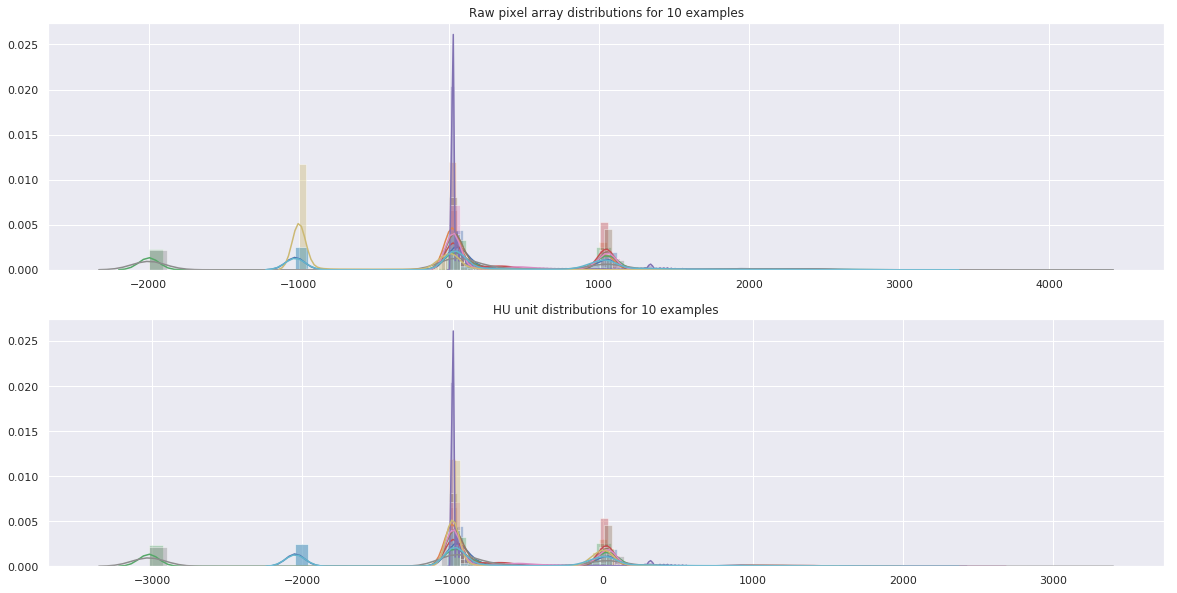

In [23]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
for file in train_files[0:10]:
    dataset = pydicom.dcmread(train_dir + file)
    image = dataset.pixel_array.flatten()
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

### Insights

* Crazy, that we observe cases with -1000 and -2000. What does that mean? We need to find it out!
* Nonetheless the mode is located at 0 for all example raw pixel value arrays. This is likely to correspond to air. Consequently our raw pixel values are not given as HU units. 
* But we can transform the image to HU units by scaling with the slope and intercept.
* Then we can see that mode is located at -1000 (HU of air).

To understand this part, the following tutorial was extremely helpful for me: https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial. Thank you a lot @Guido Zuidhof. Let's try to understand the -2000 and -3000 cases of rescaled images:

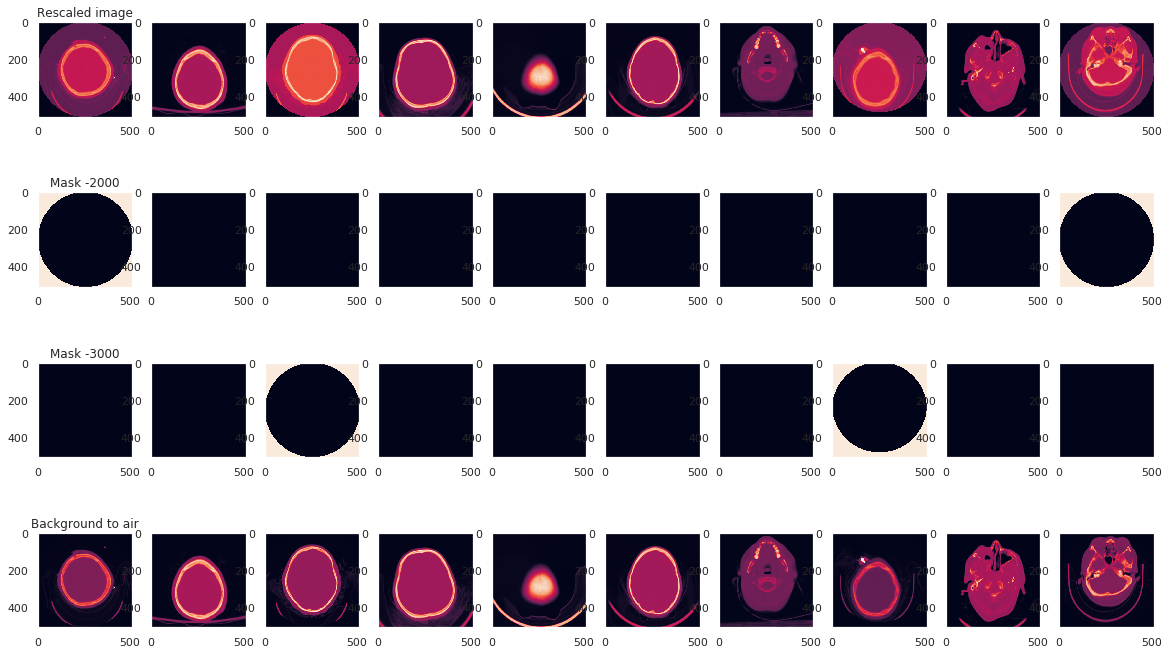

In [24]:
fig, ax = plt.subplots(4,10,figsize=(20,12))

for n in range(10):
    dataset = pydicom.dcmread(train_dir + train_files[n])
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    mask2000 = np.where((rescaled_image <= -1500) & (rescaled_image > -2500), 1, 0)
    mask3000 = np.where(rescaled_image <= -2500, 1, 0)
    ax[0,n].imshow(rescaled_image)
    rescaled_image[rescaled_image < -1024] = -1024
    ax[1,n].imshow(mask2000)
    ax[2,n].imshow(mask3000)
    ax[3,n].imshow(rescaled_image)
    ax[0,n].grid(False)
    ax[1,n].grid(False)
    ax[2,n].grid(False)
    ax[3,n].grid(False)
ax[0,0].set_title("Rescaled image")
ax[1,0].set_title("Mask -2000")
ax[2,0].set_title("Mask -3000");
ax[3,0].set_title("Background to air");

Yeah! Great! We can see that both cases (-2000 and -3000) correspond to the outside region ot cylindrical CT scanners. Consequently we can set these values to -1000 (air in HU) without worries.

## What does pixel spacing mean? <a class="anchor" id="pixelspacing"></a>

When browsing through the dicom files, we can see that a value called pixel spacing changes as well! I don't know what that means, but perhaps we can understand it by looking at some extremes.

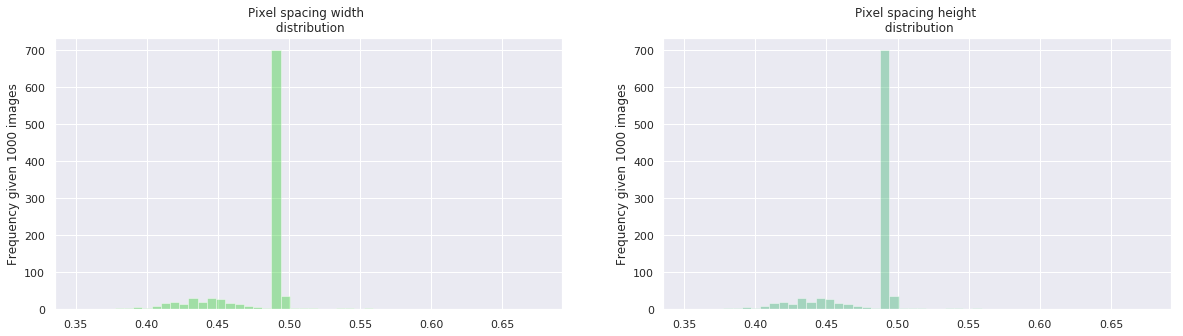

In [25]:
pixelspacing_w = []
pixelspacing_h = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    spacing = dataset.PixelSpacing
    pixelspacing_w.append(spacing[0])
    pixelspacing_h.append(spacing[1])
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_w, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing width \n distribution")
ax[0].set_ylabel("Frequency given 1000 images")
sns.distplot(pixelspacing_h, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing height \n distribution");
ax[1].set_ylabel("Frequency given 1000 images");

In [26]:
min_file = spacing_filenames[np.argmin(pixelspacing_w)]
max_file = spacing_filenames[np.argmax(pixelspacing_w)]

In [27]:
def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

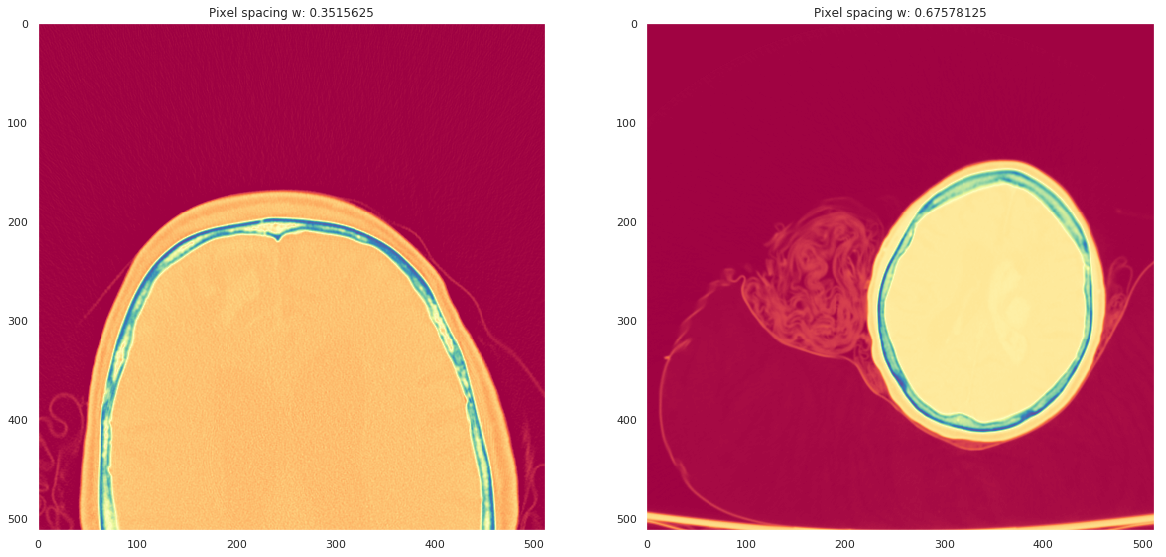

In [28]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

dataset_min = pydicom.dcmread(train_dir + min_file)
image_min = rescale_pixelarray(dataset_min)

dataset_max = pydicom.dcmread(train_dir + max_file)
image_max = rescale_pixelarray(dataset_max)

ax[0].imshow(image_min, cmap="Spectral")
ax[0].set_title("Pixel spacing w: " + str(np.min(pixelspacing_w)))
ax[1].imshow(image_max, cmap="Spectral");
ax[1].set_title("Pixel spacing w: " + str(np.max(pixelspacing_w)))
ax[0].grid(False)
ax[1].grid(False)

Hmm... still don't know what this means. Reading in the [docs](https://dicom.innolitics.com/ciods/ct-image/image-plane/00280030):

*All pixel spacing related Attributes are encoded as the physical distance between the centers of each two-dimensional pixel, specified by two numeric values.The first value is the row spacing in mm, that is the spacing between the centers of adjacent rows, or vertical spacing.The second value is the column spacing in mm, that is the spacing between the centers of adjacent columns, or horizontal spacing.*

Consequently it's related to the physical distance. Let's understand it given our extreme examples. The pixel spacing yields the mm of physical distance of one pixel. Hence we can compute the overall distance covered by one image width or height:

In [29]:
np.min(pixelspacing_w) * 512

180.0

This is the true length in mm covered by our image. In my current case (can change as listdir choses file order at random) it's 195 mm meaning 19.5 cm. 

In [30]:
np.max(pixelspacing_w) * 512

346.0

And in the maximum case it's ~500 mm, consequently 50 cm. 

What does this mean for us? It means that small heads do not automatically mean that this is a child. It could also be an adult but zoomed out. I'm expected that the dataset holds patients with varying true head sizes ranging from childrens to adults. But the resolution might differ from scan to scan even if patients show same head sizes. Nonetheless our model should still be able to detect the different types of hemorrhage. I would say it's worth to add zooming as image augmentation technique to our workflow later. What do you think? 

## The doctors windows <a class="anchor" id="docwindows"></a>

Taking a look at the dicom dataset again we can see that there is already a window center and width given for us. But what does that mean? Was this done by a doctor who set the range to visualise the hemorrhage? Is this important for our algorithm? **We should be very careful now. If we would simply put 256 shades of grey into one window this would differ from patient to patient as the given window ranges are different. Consequently we would introduce a source of variation that is not given by original HU units per image.** What to do instead?

I would like to collect window centers and width of ~1000 images to see the varity of doctos favorite windows. Then I would like to **setup a fixed window level and width that covers the majority of all window properties**. This way we can compare if a fixed custom window size is better suited that individual doctor window sizes. 



In [31]:
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

In [32]:
window_widths = []
window_levels = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    win_width = get_window_value(dataset.WindowWidth)
    win_center = get_window_value(dataset.WindowCenter)
    window_widths.append(win_width)
    window_levels.append(win_center)
    spacing_filenames.append(file)

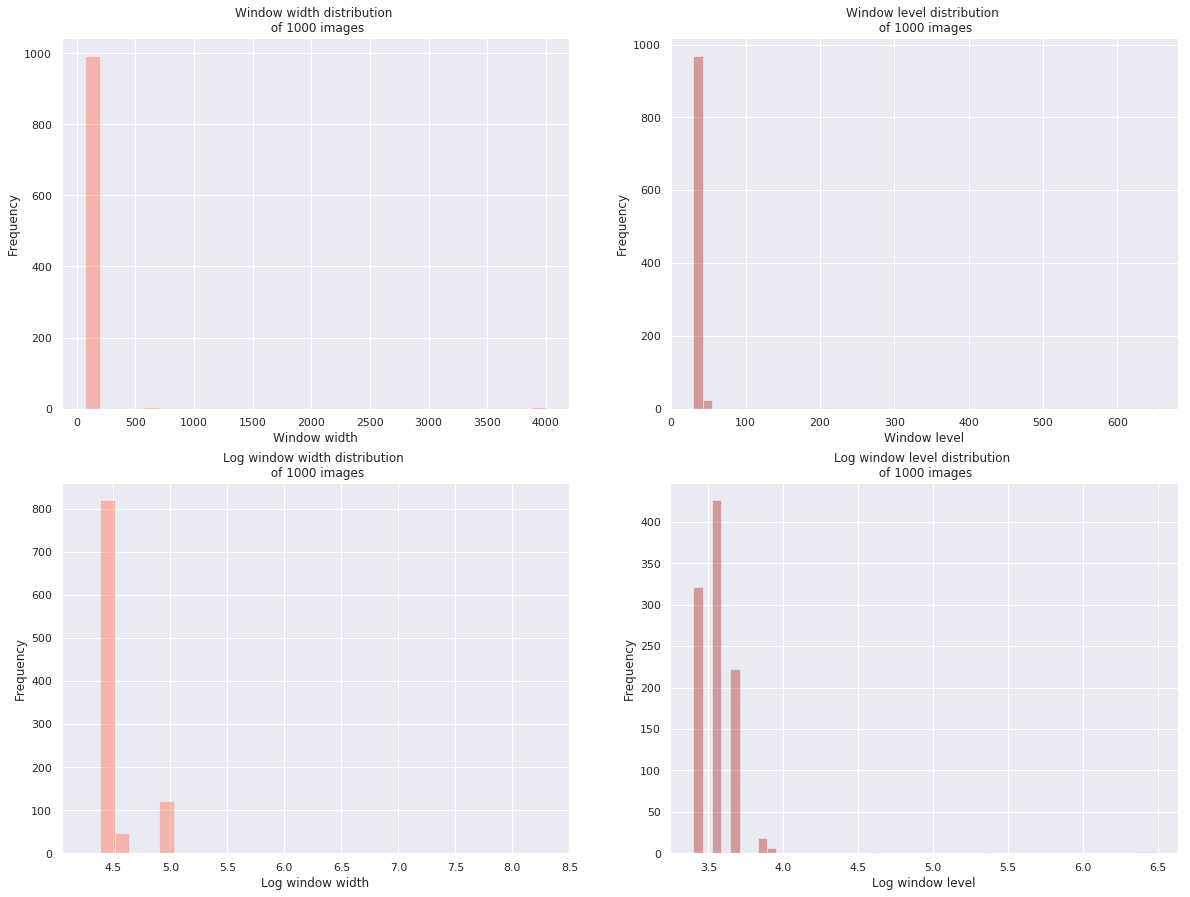

In [33]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.distplot(window_widths, kde=False, ax=ax[0,0], color="Tomato")
ax[0,0].set_title("Window width distribution \n of 1000 images")
ax[0,0].set_xlabel("Window width")
ax[0,0].set_ylabel("Frequency")

sns.distplot(window_levels, kde=False, ax=ax[0,1], color="Firebrick")
ax[0,1].set_title("Window level distribution \n of 1000 images")
ax[0,1].set_xlabel("Window level")
ax[0,1].set_ylabel("Frequency")

sns.distplot(np.log(window_widths), kde=False, ax=ax[1,0], color="Tomato")
ax[1,0].set_title("Log window width distribution \n of 1000 images")
ax[1,0].set_xlabel("Log window width")
ax[1,0].set_ylabel("Frequency")

sns.distplot(np.log(window_levels), kde=False, ax=ax[1,1], color="Firebrick")
ax[1,1].set_title("Log window level distribution \n of 1000 images")
ax[1,1].set_xlabel("Log window level")
ax[1,1].set_ylabel("Frequency");

### Insights

* Uhh! Very bad! Do you see it? There are extreme outliers in the window widths and centers. This does not make sense! I would have expected the doctos to focus on the brain tissue and we have already learnt that HU values are roughly between 8-70 in these cases. 
* Let's explore if we are better by focusing on our own window size! ;-)

## My custom window <a class="anchor" id="customwindow"></a>

Ok, let's setup our own window width and center:

In [34]:
doc_windows = pd.DataFrame(index=spacing_filenames, columns=["win_width", "win_level"])
doc_windows["win_width"] = window_widths
doc_windows["win_level"] = window_levels
doc_windows.head(20)

,win_width,win_level
ID_231d901c1.dcm,100,40
ID_994bc0470.dcm,80,47
ID_127689cce.dcm,80,30
ID_25457734a.dcm,80,36
ID_81c9aa125.dcm,80,36
ID_87e8b2528.dcm,80,40
ID_9bc43a883.dcm,80,36
ID_df0ba5e5a.dcm,80,30
ID_69eb48ed6.dcm,80,40
ID_c5c23af94.dcm,150,40


In [35]:
doc_windows[doc_windows.win_width==doc_windows.win_width.median()]

,win_width,win_level
ID_994bc0470.dcm,80,47
ID_127689cce.dcm,80,30
ID_25457734a.dcm,80,36
ID_81c9aa125.dcm,80,36
ID_87e8b2528.dcm,80,40
...,...,...
ID_4cf55cbb6.dcm,80,40
ID_92fed7252.dcm,80,36
ID_14ff70cd1.dcm,80,40
ID_19a812260.dcm,80,40


In [36]:
doc_windows.describe()

,win_width,win_level
count,1000.000000,1000.00000
mean,102.282000,37.28900
std,216.817509,33.59369
min,70.000000,30.00000
25%,80.000000,30.00000
50%,80.000000,36.00000
75%,80.000000,40.00000
max,4000.000000,650.00000


In [37]:
np.quantile(window_widths, 0.95)

150.0

In [38]:
np.quantile(window_levels, 0.95)

40.0

* The majority of centers is located between 30 and 40 HUs.
* In contrast the widths of windows vary between 70 to 150 HUs.

Now, let's setup a window that is centered at 30 and has a width of 80. This would be close to the median for both cases. Furthermore we have seen such combinations of width and center in our doc_windows dataframe.

In [39]:
def set_manual_window(hu_image, custom_center, custom_width):
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = max_value
    return hu_image

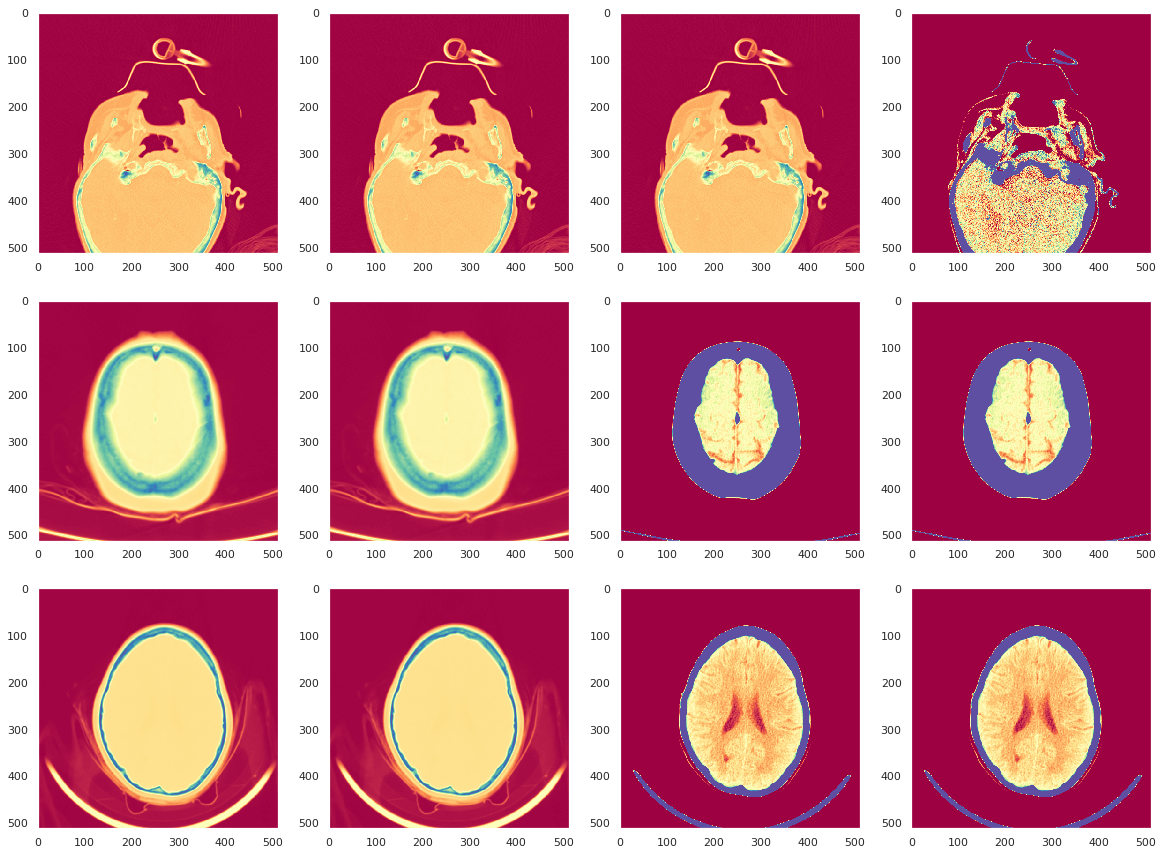

In [40]:
fig, ax = plt.subplots(3,4,figsize=(20,15))

docs_dict = {"ID_352b300f9.dcm": {"width": 4000, "level": 600},
             "ID_7e7d7633a.dcm": {"width": 70, "level": 30},
             "ID_87e8b2528.dcm": {"width": 80, "level": 40}}
n = 0
for file in ["ID_352b300f9.dcm", "ID_7e7d7633a.dcm", "ID_87e8b2528.dcm"]:
    dataset = pydicom.dcmread(train_dir + file)
    pixelarray = dataset.pixel_array
    ax[n,0].imshow(pixelarray, cmap="Spectral")
    ax[n,0].grid(False)
    rescaled_image = rescale_pixelarray(dataset)
    ax[n,1].imshow(rescaled_image, cmap="Spectral")
    ax[n,1].grid(False)
    
    org_windowed_image = set_manual_window(rescaled_image, docs_dict[file]["level"], docs_dict[file]["width"])
    ax[n,2].imshow(org_windowed_image, cmap="Spectral")
    ax[n,2].grid(False)
    
    new_windowed_image = set_manual_window(rescaled_image, 40, 150)
    ax[n,3].imshow(new_windowed_image, cmap="Spectral")
    ax[n,3].grid(False)
    
    n+=1

### Insights

* The first extreme case seems to be faulty. After windowing to a center of 40 and width of 150 we can't see the same nice patterns as for the min and the median cases.
* By windowing to the same window we can't see differences between the median and the min case. But pixel values differ! 

## The image shape <a class="anchor" id="imageshape"></a>

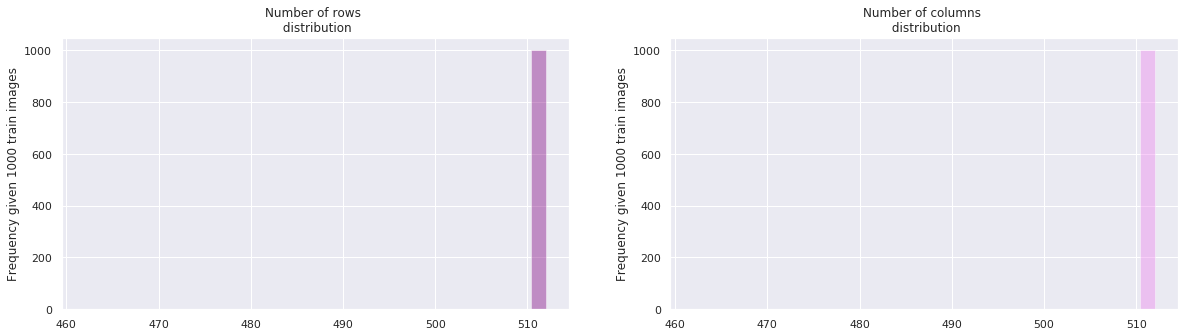

In [41]:
num_rows = []
num_cols = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    num_rows.append(dataset.Rows)
    num_cols.append(dataset.Columns)
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(num_rows, ax=ax[0], color="Purple", kde=False)
ax[0].set_title("Number of rows \n distribution")
ax[0].set_ylabel("Frequency given 1000 train images")
sns.distplot(num_cols, ax=ax[1], color="Violet", kde=False)
ax[1].set_title("Number of columns \n distribution");
ax[1].set_ylabel("Frequency given 1000 train images");

Ok it seems that most images are of shape 512x512. But I don't know if we can be sure about it. Is it possible that this can change from stage 1 to stage 2? What about the test data?

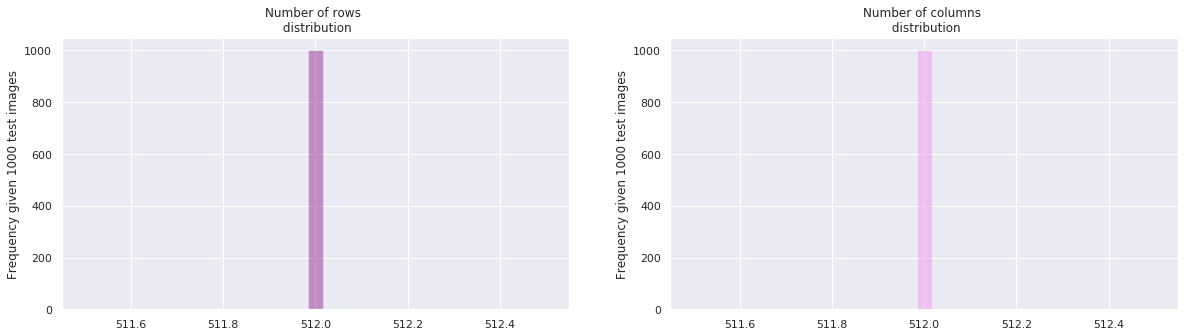

In [42]:
num_rows = []
num_cols = []
spacing_filenames = []
for file in test_files[0:1000]:
    dataset = pydicom.dcmread(test_dir + file)
    num_rows.append(dataset.Rows)
    num_cols.append(dataset.Columns)
    spacing_filenames.append(file)

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(num_rows, ax=ax[0], color="Purple", kde=False)
ax[0].set_title("Number of rows \n distribution")
ax[0].set_ylabel("Frequency given 1000 test images")
sns.distplot(num_cols, ax=ax[1], color="Violet", kde=False)
ax[1].set_title("Number of columns \n distribution");
ax[1].set_ylabel("Frequency given 1000 test images");

Ok for stage 1 this holds as well.

## Where to go next?

The kernel had been much longer in the past, but .... I reached the end of the kaggle kernel world by exceeding the maximum kernel length that can be displayed. Jackpot - This was the first time for me! :-) 

<img src="https://cdn.pixabay.com/photo/2017/05/26/11/37/worlds-end-2345861_1280.jpg" width="600px">

I'm sorry that this happend. Have to learn how to keep complex stuff simple, more concise and light-weighted. If you like to continue with the modelling part - you can find it here:

https://www.kaggle.com/allunia/rsna-ih-detection-baseline

Happy kaggling!